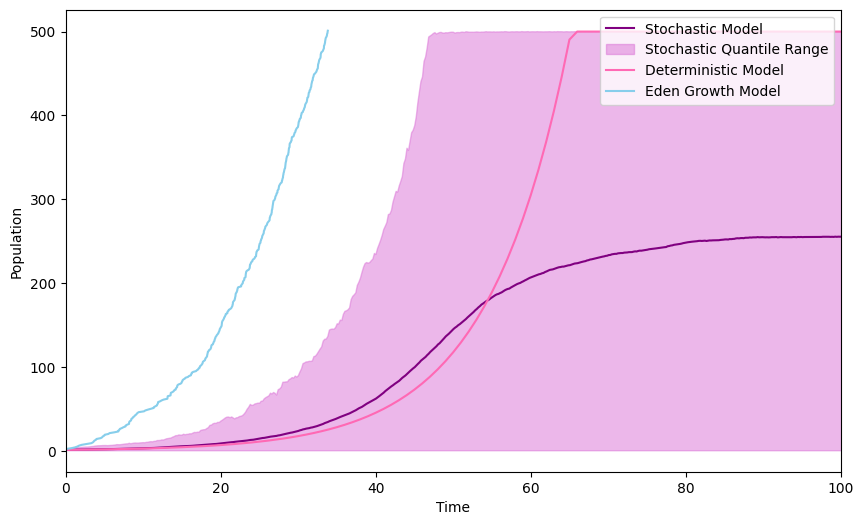

Stochastic Model Extinction Probability: 0.48


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Exponential Model
def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.02, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    carrying_capacity = params['carrying_capacity']
    max_time = params['max_time']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        next_event_time = np.random.exponential(1 / (death_rate * population + birth_rate * population))
        
        if np.random.rand() < birth_rate / (birth_rate + death_rate) and population < carrying_capacity:
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.quantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.quantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Deterministic Exponential Model
def exp_growth_model(b, d, K, P0, time_steps, dt):
    r = b - d
    population = np.zeros(time_steps)
    population[0] = P0

    for t in range(1, time_steps):
        P = population[t-1]
        dP = r * P
        population[t] = P + dP
        if population[t] >= K:
            population[t:] = K
            break

    return population

# Eden Growth Model
def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1  # Start with a single occupied cell in the center
    border = set(get_moore_neighborhood(center, center, size))
    return grid, border

def get_moore_neighborhood(x, y, size):
    neighbors = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (0 <= i < size and 0 <= j < size)]
    neighbors.remove((x, y))
    return neighbors

def grow_cluster(grid, border, iterations, growth_rate):
    size = grid.shape[0]
    population_size = []
    time_points = [0]  # Start with time zero

    for _ in range(iterations):
        if not border:
            break

        next_event_time = np.random.exponential(1 / (growth_rate * len(border)))
        time_points.append(time_points[-1] + next_event_time)

        new_site = list(border)[np.random.randint(len(border))]
        grid[new_site] = 1
        population_size.append(np.sum(grid))
        border.remove(new_site)
        
        for nx, ny in get_moore_neighborhood(*new_site, size):
            if grid[nx, ny] == 0:
                border.add((nx, ny))
    
    return grid, population_size, time_points[:-1]  # make time_points and population_size the same length

# Plot Comparison Function
def plot_population_comparison(stochastic_time_points, avg_population, lower_quantile, upper_quantile, det_population, eden_time_points, eden_population, K, time_steps):
    plt.figure(figsize=(10, 6))
    plt.plot(stochastic_time_points, avg_population, color='purple', label='Stochastic Model')
    plt.fill_between(stochastic_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    plt.plot(range(time_steps), det_population, color='hotpink', label='Deterministic Model')
    plt.plot(eden_time_points, eden_population, color='skyblue', label='Eden Growth Model')
    plt.xlim(0,100)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend(loc='upper right')
    plt.show()

# Run models and plot the results
if __name__ == "__main__":
    # Stochastic Model Parameters and Simulation
    stochastic_params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1, carrying_capacity=500, max_time=200)
    num_simulations = 100
    avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, extinction_prob = run_multiple_simulations_with_quantiles(stochastic_params, num_simulations)
    
    # Deterministic Model Parameters and Simulation
    b = 0.2  # birth rate
    d = 0.1  # death rate
    K = 500  # carrying capacity
    P0 = 1  # initial population
    time_steps = 200  # number of time steps
    dt = 1  # time step size

    det_population = exp_growth_model(b, d, K, P0, time_steps, dt)
    
    # Eden Growth Model Simulation
    grid_size = 100
    iterations = 500
    growth_rate = 0.1
    runs = 100

    all_population_sizes = []
    for _ in range(runs):
        grid, eden_population_size, eden_time_points = grow_cluster(*initialize_grid(grid_size), iterations, growth_rate)
        all_population_sizes.append(eden_population_size)

    eden_average_population_size = np.mean(all_population_sizes, axis=0)
    eden_time_points = np.mean([eden_time_points for _ in range(runs)], axis=0)

    # Plot Comparison
    plot_population_comparison(avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, det_population, eden_time_points, eden_average_population_size, K, time_steps)
    
    # Print Extinction Probability
    print(f"Stochastic Model Extinction Probability: {extinction_prob:.2f}")


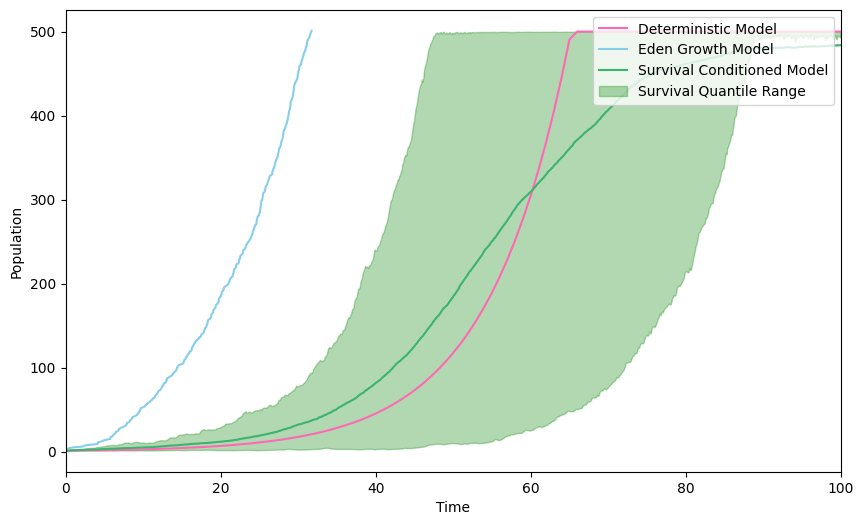

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Exponential Model
def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.02, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    carrying_capacity = params['carrying_capacity']
    max_time = params['max_time']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        next_event_time = np.random.exponential(1 / (death_rate * population + birth_rate * population))
        
        if np.random.rand() < birth_rate / (birth_rate + death_rate) and population < carrying_capacity:
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.quantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.quantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Deterministic Exponential Model
def exp_growth_model(b, d, K, P0, time_steps, dt):
    r = b - d
    population = np.zeros(time_steps)
    population[0] = P0

    for t in range(1, time_steps):
        P = population[t-1]
        dP = r * P
        population[t] = P + dP
        if population[t] >= K:
            population[t:] = K
            break

    return population

# Eden Growth Model
def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1  # Start with a single occupied cell in the center
    border = set(get_moore_neighborhood(center, center, size))
    return grid, border

def get_moore_neighborhood(x, y, size):
    neighbors = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (0 <= i < size and 0 <= j < size)]
    neighbors.remove((x, y))
    return neighbors

def grow_cluster(grid, border, iterations, growth_rate):
    size = grid.shape[0]
    population_size = []
    time_points = [0]  # Start with time zero

    for _ in range(iterations):
        if not border:
            break

        next_event_time = np.random.exponential(1 / (growth_rate * len(border)))
        time_points.append(time_points[-1] + next_event_time)

        new_site = list(border)[np.random.randint(len(border))]
        grid[new_site] = 1
        population_size.append(np.sum(grid))
        border.remove(new_site)
        
        for nx, ny in get_moore_neighborhood(*new_site, size):
            if grid[nx, ny] == 0:
                border.add((nx, ny))
    
    return grid, population_size, time_points[:-1]  # make time_points and population_size the same length

# Survival Conditioned Model
def run_multiple_simulations_with_quantiles_survival(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']

    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    non_extinct_populations = [pop for pop in all_population_sizes if pop[-1] > 0]
    non_extinct_times = [time for time, pop in zip(all_time_points, all_population_sizes) if pop[-1] > 0]
    non_extinct_interpolations = np.zeros((len(non_extinct_populations), num_points))

    for i, (time, pop) in enumerate(zip(non_extinct_times, non_extinct_populations)):
        non_extinct_interpolations[i] = np.interp(average_time_points, time, pop)

    average_population_sizes = np.mean(non_extinct_interpolations, axis=0)
    lower_quantile = np.quantile(non_extinct_interpolations, 0.05, axis=0)
    upper_quantile = np.quantile(non_extinct_interpolations, 0.95, axis=0)

    extinction_probability = extinction_count / num_simulations

    return average_time_points, non_extinct_interpolations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Plot Comparison Function
def plot_population_comparison(stochastic_time_points, avg_population, lower_quantile, upper_quantile, det_population, eden_time_points, eden_population, survival_time_points, survival_population, survival_lower_quantile, survival_upper_quantile, K, time_steps):
    plt.figure(figsize=(10, 6))
    #plt.plot(stochastic_time_points, avg_population, color='purple', label='Stochastic Model')
    #plt.fill_between(stochastic_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    plt.plot(range(time_steps), det_population, color='hotpink', label='Deterministic Model')
    plt.plot(eden_time_points, eden_population, color='skyblue', label='Eden Growth Model')
    
    # Adding Survival Conditioned Model
    plt.plot(survival_time_points, survival_population, color='mediumseagreen', label='Survival Conditioned Model')
    plt.fill_between(survival_time_points, survival_lower_quantile, survival_upper_quantile, color='green', alpha=0.3, label='Survival Quantile Range')
    plt.xlim(0,100)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend(loc='upper right')
    plt.show()

# Run models and plot the results
if __name__ == "__main__":
    # Stochastic Model Parameters and Simulation
    stochastic_params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1, carrying_capacity=500, max_time=200)
    num_simulations = 100
    avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, extinction_prob = run_multiple_simulations_with_quantiles(stochastic_params, num_simulations)
    
    # Deterministic Model Parameters and Simulation
    b = 0.2  # birth rate
    d = 0.1  # death rate
    K = 500  # carrying capacity
    P0 = 1  # initial population
    time_steps = 200  # number of time steps
    dt = 1  # time step size

    det_population = exp_growth_model(b, d, K, P0, time_steps, dt)
    
    # Eden Growth Model Simulation
    grid_size = 100
    iterations = 500
    growth_rate = 0.1
    runs = 100

    all_population_sizes = []
    for _ in range(runs):
        grid, eden_population_size, eden_time_points = grow_cluster(*initialize_grid(grid_size), iterations, growth_rate)
        all_population_sizes.append(eden_population_size)

    eden_average_population_size = np.mean(all_population_sizes, axis=0)
    eden_time_points = np.mean([eden_time_points for _ in range(runs)], axis=0)
    
    # Survival Conditioned Model Simulation
    survival_params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1, carrying_capacity=500)
    survival_time_points, non_extinct_interpolations, survival_population, survival_lower_quantile, survival_upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles_survival(survival_params, num_simulations)

    # Plot Comparison
    plot_population_comparison(avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, det_population, eden_time_points, eden_average_population_size, survival_time_points, survival_population, survival_lower_quantile, survival_upper_quantile, K, time_steps)
    
    # Print Extinction Probability
    #print(f"Stochastic Model Extinction Probability: {extinction_prob:.2f}")
    #print(f"Survival Conditioned Model Extinction Probability: {extinction_probability:.2f}")
